In [ ]:
# !conda install -q -U bitsandbytes
# !conda install -q xformers
# !conda install -q -U git+https://github.com/huggingface/transformers.git
# !conda install -q -U git+https://github.com/huggingface/peft.git
# !conda install -q -U git+https://github.com/huggingface/accelerate.git
# !conda install -q datasets
# !conda install -q einops
# !conda install -q wandb
# !conda install -q scipy

In [1]:
from huggingface_hub import login
login()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
import pandas as pd
from datasets import load_dataset

SQL_SPECIAL_TOKENS = {
    'schema': '<|schema|>',
    'query': '<|query|>',
    'sql': '<|sql|>',
    'endoftext': '<|endoftext|>',
}

def generate_prompt(examples, spider_schemas, use_fields=False):
    """
    Generates the prompt for the given example as follows:
    <|schema|> DATABASE STRUCTURE <|query|> NATURAL LANGUAGE QUESTION <|sql|> SQL QUERY <|endoftext|>

    examples: The example to generate the prompt for.
    spider_schemas: The spider schemas object.
    use_fields: Whether to use the database fields in the prompt.
    """
    prompt = ''

    if use_fields:
      fields = SQL_SPECIAL_TOKENS['schema'] + spider_schemas.get_db_schema(examples['db_id']) + SQL_SPECIAL_TOKENS['endoftext']
      fields.strip()
      prompt += fields

    question = SQL_SPECIAL_TOKENS['query'] + examples['question'] + SQL_SPECIAL_TOKENS['endoftext']
    question.strip()
    prompt += question

    query = SQL_SPECIAL_TOKENS['sql'] + examples['query']
    query.strip()

    if not query.endswith(';'):
        query = query + ';'
    query = query + SQL_SPECIAL_TOKENS['endoftext']

    prompt += query

    return prompt.lower()

def preprocess_function(examples, spider_schema, use_fields=False):
    prompts = generate_prompt(examples, spider_schema, use_fields)
    return {'input_text': prompts}

class SpiderSchema:
    """
    Class to handle the spider dataset schemas.
    """
    def __init__(self, table_json: str):
        self.schema, self.primary, self.foreign = self.get_spider_schemas(table_json)

    def find_db_fields(self, db_name: str):
        """
        Returns the fields of the database with the given name as a string.
        """
        df = self.schema[self.schema['Database name'] == db_name]
        df = df.groupby(' Table Name')
        output = ""
        for name, group in df:
            output += "Table " +name+ ', columns = ['
            for index, row in group.iterrows():
                output += row[" Field Name"]+','
            output = output[:-1]
            output += "]\n"
        return output

    def find_db_primary_keys(self, db_name: str):
        """
        Returns the primary keys of the database with the given name as a string.
        """
        df = self.primary[self.primary['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['Table Name'] + '.' + row['Primary Key'] +','
        if len(output)>1:
            output = output[:-1]
        output += "]\n"
        return output

    def find_db_foreign_keys(self, db_name: str):
        """
        Returns the foreign keys of the database with the given name as a string.
        """
        df = self.foreign[self.foreign['Database name'] == db_name]
        output = "["
        for index, row in df.iterrows():
            output += row['First Table Name'] + '.' + row['First Table Foreign Key'] + " = " + row['Second Table Name'] + '.' + row['Second Table Foreign Key'] + ','
        output= output[:-1] + "]"
        return output

    def get_db_schema(self, db_name: str) -> str:
        """
        Returns the schema of the database with the given name as a string.
        """
        fields = self.find_db_fields(db_name)
        fields += "Foreign_keys = " + self.find_db_primary_keys(db_name) + '\n'
        fields += "Primary_keys = " + self.find_db_foreign_keys(db_name)
        return fields

    @staticmethod
    def get_spider_schemas(table_json: str):
        """
        Returns the schemas of the spider dataset as pandas dataframes, with the following columns:
        - spider_schema: Database name, Table Name, Field Name, Type
        - spider_primary: Database name, Table Name, Primary Key
        - spider_foreign: Database name, First Table Name, Second Table Name, First Table Foreign Key, Second Table Foreign Key

        :param table_json: path to the table.json file of the spider dataset
        :return: spider_schema, spider_primary, spider_foreign
        """
        schema_df = pd.read_json(table_json)
        schema_df = schema_df.drop(['column_names','table_names'], axis=1)
        schema = []
        f_keys = []
        p_keys = []
        for index, row in schema_df.iterrows():
            tables = row['table_names_original']
            col_names = row['column_names_original']
            col_types = row['column_types']
            foreign_keys = row['foreign_keys']
            primary_keys = row['primary_keys']
            for col, col_type in zip(col_names, col_types):
                index, col_name = col
                if index == -1:
                    for table in tables:
                        schema.append([row['db_id'], table, '*', 'text'])
                else:
                    schema.append([row['db_id'], tables[index], col_name, col_type])
            for primary_key in primary_keys:
                index, column = col_names[primary_key]
                p_keys.append([row['db_id'], tables[index], column])
            for foreign_key in foreign_keys:
                first, second = foreign_key
                first_index, first_column = col_names[first]
                second_index, second_column = col_names[second]
                f_keys.append([row['db_id'], tables[first_index], tables[second_index], first_column, second_column])
        spider_schema = pd.DataFrame(schema, columns=['Database name', ' Table Name', ' Field Name', ' Type'])
        spider_primary = pd.DataFrame(p_keys, columns=['Database name', 'Table Name', 'Primary Key'])
        spider_foreign = pd.DataFrame(f_keys,
                            columns=['Database name', 'First Table Name', 'Second Table Name', 'First Table Foreign Key',
                                    'Second Table Foreign Key'])
        return spider_schema, spider_primary, spider_foreign


def get_dataset(table_json: str, dataset_name: str='spider', use_fields: bool = False):

    dataset = load_dataset(dataset_name)
    spider_schema = SpiderSchema(table_json)
    dataset = dataset.map(
        lambda examples: preprocess_function(examples, spider_schema, use_fields),
        remove_columns=dataset["train"].column_names,
    )
    return dataset

In [2]:
model_id = "tiiuae/falcon-7b"
dataset_id = 'spider'
spider_schema = './tables.json'

In [3]:
dataset = get_dataset(spider_schema, dataset_id, use_fields=True)

Found cached dataset spider (C:/Users/GODZILLA/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class InferenceDataset(Dataset):
    """
    Dataset for inference.

    Arguments:
        dataset: The dataset to use.
        prefix: The prefix to use for the prompt.
    """

    def __init__(self, dataset, prefix = 'Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.'):
        self.dataset = dataset
        self.prefix = prefix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.dataset[idx]

        return self.prefix + sample['input_text'].split('<|sql|>')[0] + '<|sql|>'

In [5]:
eval_batch_size = 1

inference_ds = InferenceDataset(dataset['validation'])
inference_dataloader = DataLoader(inference_ds, batch_size=eval_batch_size, shuffle=False)

In [15]:
a = ['<|schema|>table people, columns = [*,people_id,nationality,name,birth_date,height]\ntable poker_player, columns = [*,poker_player_id,people_id,final_table_made,best_finish,money_rank,earnings]\nforeign_keys = [poker_player.poker_player_id,people.people_id]\n\nprimary_keys = [poker_player.people_id = people.people_id]<|endoftext|><|query|>what is the average earnings of poker players?<|endoftext|><|sql|>',
 '<|schema|>table city, columns = [*,id,name,countrycode,district,population]\ntable country, columns = [*,code,name,continent,region,surfacearea,indepyear,population,lifeexpectancy,gnp,gnpold,localname,governmentform,headofstate,capital,code2]\ntable countrylanguage, columns = [*,countrycode,language,isofficial,percentage]\ntable sqlite_sequence, columns = [*,name,seq]\nforeign_keys = [city.id,country.code,countrylanguage.countrycode]\n\nprimary_keys = [city.countrycode = country.code,countrylanguage.countrycode = country.code]<|endoftext|><|query|>what is the total population of gelderland district?<|endoftext|><|sql|>',
 '<|schema|>table city, columns = [*,id,name,countrycode,district,population]\ntable country, columns = [*,code,name,continent,region,surfacearea,indepyear,population,lifeexpectancy,gnp,gnpold,localname,governmentform,headofstate,capital,code2]\ntable countrylanguage, columns = [*,countrycode,language,isofficial,percentage]\ntable sqlite_sequence, columns = [*,name,seq]\nforeign_keys = [city.id,country.code,countrylanguage.countrycode]\n\nprimary_keys = [city.countrycode = country.code,countrylanguage.countrycode = country.code]<|endoftext|><|query|>how many type of governments are in africa?<|endoftext|><|sql|>',
 '<|schema|>table airlines, columns = [*,uid,airline,abbreviation,country]\ntable airports, columns = [*,city,airportcode,airportname,country,countryabbrev]\ntable flights, columns = [*,airline,flightno,sourceairport,destairport]\nforeign_keys = [airlines.uid,airports.airportcode,flights.airline]\n\nprimary_keys = [flights.destairport = airports.airportcode,flights.sourceairport = airports.airportcode]<|endoftext|><|query|>how many flights have destination ato?<|endoftext|><|sql|>',
 '<|schema|>table airlines, columns = [*,uid,airline,abbreviation,country]\ntable airports, columns = [*,city,airportcode,airportname,country,countryabbrev]\ntable flights, columns = [*,airline,flightno,sourceairport,destairport]\nforeign_keys = [airlines.uid,airports.airportcode,flights.airline]\n\nprimary_keys = [flights.destairport = airports.airportcode,flights.sourceairport = airports.airportcode]<|endoftext|><|query|>which abbreviation corresponds to jetblue airways?<|endoftext|><|sql|>',
 '<|schema|>table friend, columns = [*,student_id,friend_id]\ntable highschooler, columns = [*,id,name,grade]\ntable likes, columns = [*,student_id,liked_id]\nforeign_keys = [highschooler.id,friend.student_id,likes.student_id]\n\nprimary_keys = [friend.friend_id = highschooler.id,friend.student_id = highschooler.id,likes.student_id = highschooler.id,likes.liked_id = highschooler.id]<|endoftext|><|query|>what is the grade of each high schooler?<|endoftext|><|sql|>',
 '<|schema|>table people, columns = [*,people_id,nationality,name,birth_date,height]\ntable poker_player, columns = [*,poker_player_id,people_id,final_table_made,best_finish,money_rank,earnings]\nforeign_keys = [poker_player.poker_player_id,people.people_id]\n\nprimary_keys = [poker_player.people_id = people.people_id]<|endoftext|><|query|>return the names of all the poker players.<|endoftext|><|sql|>',
 '<|schema|>table addresses, columns = [*,address_id,line_1,line_2,line_3,city,zip_postcode,state_province_county,country,other_address_details]\ntable courses, columns = [*,course_id,course_name,course_description,other_details]\ntable degree_programs, columns = [*,degree_program_id,department_id,degree_summary_name,degree_summary_description,other_details]\ntable departments, columns = [*,department_id,department_name,department_description,other_details]\ntable sections, columns = [*,section_id,course_id,section_name,section_description,other_details]\ntable semesters, columns = [*,semester_id,semester_name,semester_description,other_details]\ntable student_enrolment, columns = [*,student_enrolment_id,degree_program_id,semester_id,student_id,other_details]\ntable student_enrolment_courses, columns = [*,student_course_id,course_id,student_enrolment_id]\ntable students, columns = [*,student_id,current_address_id,permanent_address_id,first_name,middle_name,last_name,cell_mobile_number,email_address,ssn,date_first_registered,date_left,other_student_details]\ntable transcript_contents, columns = [*,student_course_id,transcript_id]\ntable transcripts, columns = [*,transcript_id,transcript_date,other_details]\nforeign_keys = [addresses.address_id,courses.course_id,departments.department_id,degree_programs.degree_program_id,sections.section_id,semesters.semester_id,students.student_id,student_enrolment.student_enrolment_id,student_enrolment_courses.student_course_id,transcripts.transcript_id]\n\nprimary_keys = [degree_programs.department_id = departments.department_id,sections.course_id = courses.course_id,students.permanent_address_id = addresses.address_id,students.current_address_id = addresses.address_id,student_enrolment.student_id = students.student_id,student_enrolment.semester_id = semesters.semester_id,student_enrolment.degree_program_id = degree_programs.degree_program_id,student_enrolment_courses.student_enrolment_id = student_enrolment.student_enrolment_id,student_enrolment_courses.course_id = courses.course_id,transcript_contents.transcript_id = transcripts.transcript_id,transcript_contents.student_course_id = student_enrolment_courses.student_course_id]<|endoftext|><|query|>how many different addresses do the students currently live?<|endoftext|><|sql|>',
 '<|schema|>table documents, columns = [*,document_id,template_id,document_name,document_description,other_details]\ntable paragraphs, columns = [*,paragraph_id,document_id,paragraph_text,other_details]\ntable ref_template_types, columns = [*,template_type_code,template_type_description]\ntable templates, columns = [*,template_id,version_number,template_type_code,date_effective_from,date_effective_to,template_details]\nforeign_keys = [ref_template_types.template_type_code,templates.template_id,documents.document_id,paragraphs.paragraph_id]\n\nprimary_keys = [templates.template_type_code = ref_template_types.template_type_code,documents.template_id = templates.template_id,paragraphs.document_id = documents.document_id]<|endoftext|><|query|>show all template type codes with less than three templates.<|endoftext|><|sql|>',
 '<|schema|>table city, columns = [*,id,name,countrycode,district,population]\ntable country, columns = [*,code,name,continent,region,surfacearea,indepyear,population,lifeexpectancy,gnp,gnpold,localname,governmentform,headofstate,capital,code2]\ntable countrylanguage, columns = [*,countrycode,language,isofficial,percentage]\ntable sqlite_sequence, columns = [*,name,seq]\nforeign_keys = [city.id,country.code,countrylanguage.countrycode]\n\nprimary_keys = [city.countrycode = country.code,countrylanguage.countrycode = country.code]<|endoftext|><|query|>what is the continent name which anguilla belongs to?<|endoftext|><|sql|>',
 '<|schema|>table people, columns = [*,people_id,nationality,name,birth_date,height]\ntable poker_player, columns = [*,poker_player_id,people_id,final_table_made,best_finish,money_rank,earnings]\nforeign_keys = [poker_player.poker_player_id,people.people_id]\n\nprimary_keys = [poker_player.people_id = people.people_id]<|endoftext|><|query|>return the nationalities for which there are two or more people.<|endoftext|><|sql|>',
 '<|schema|>table people, columns = [*,people_id,nationality,name,birth_date,height]\ntable poker_player, columns = [*,poker_player_id,people_id,final_table_made,best_finish,money_rank,earnings]\nforeign_keys = [poker_player.poker_player_id,people.people_id]\n\nprimary_keys = [poker_player.people_id = people.people_id]<|endoftext|><|query|>what are the names of people who are not from russia?<|endoftext|><|sql|>',
 "<|schema|>table addresses, columns = [*,address_id,line_1,line_2,line_3,city,zip_postcode,state_province_county,country,other_address_details]\ntable courses, columns = [*,course_id,course_name,course_description,other_details]\ntable degree_programs, columns = [*,degree_program_id,department_id,degree_summary_name,degree_summary_description,other_details]\ntable departments, columns = [*,department_id,department_name,department_description,other_details]\ntable sections, columns = [*,section_id,course_id,section_name,section_description,other_details]\ntable semesters, columns = [*,semester_id,semester_name,semester_description,other_details]\ntable student_enrolment, columns = [*,student_enrolment_id,degree_program_id,semester_id,student_id,other_details]\ntable student_enrolment_courses, columns = [*,student_course_id,course_id,student_enrolment_id]\ntable students, columns = [*,student_id,current_address_id,permanent_address_id,first_name,middle_name,last_name,cell_mobile_number,email_address,ssn,date_first_registered,date_left,other_student_details]\ntable transcript_contents, columns = [*,student_course_id,transcript_id]\ntable transcripts, columns = [*,transcript_id,transcript_date,other_details]\nforeign_keys = [addresses.address_id,courses.course_id,departments.department_id,degree_programs.degree_program_id,sections.section_id,semesters.semester_id,students.student_id,student_enrolment.student_enrolment_id,student_enrolment_courses.student_course_id,transcripts.transcript_id]\n\nprimary_keys = [degree_programs.department_id = departments.department_id,sections.course_id = courses.course_id,students.permanent_address_id = addresses.address_id,students.current_address_id = addresses.address_id,student_enrolment.student_id = students.student_id,student_enrolment.semester_id = semesters.semester_id,student_enrolment.degree_program_id = degree_programs.degree_program_id,student_enrolment_courses.student_enrolment_id = student_enrolment.student_enrolment_id,student_enrolment_courses.course_id = courses.course_id,transcript_contents.transcript_id = transcripts.transcript_id,transcript_contents.student_course_id = student_enrolment_courses.student_course_id]<|endoftext|><|query|>how is the math course described?<|endoftext|><|sql|>",
 '<|schema|>table addresses, columns = [*,address_id,line_1,line_2,line_3,city,zip_postcode,state_province_county,country,other_address_details]\ntable courses, columns = [*,course_id,course_name,course_description,other_details]\ntable degree_programs, columns = [*,degree_program_id,department_id,degree_summary_name,degree_summary_description,other_details]\ntable departments, columns = [*,department_id,department_name,department_description,other_details]\ntable sections, columns = [*,section_id,course_id,section_name,section_description,other_details]\ntable semesters, columns = [*,semester_id,semester_name,semester_description,other_details]\ntable student_enrolment, columns = [*,student_enrolment_id,degree_program_id,semester_id,student_id,other_details]\ntable student_enrolment_courses, columns = [*,student_course_id,course_id,student_enrolment_id]\ntable students, columns = [*,student_id,current_address_id,permanent_address_id,first_name,middle_name,last_name,cell_mobile_number,email_address,ssn,date_first_registered,date_left,other_student_details]\ntable transcript_contents, columns = [*,student_course_id,transcript_id]\ntable transcripts, columns = [*,transcript_id,transcript_date,other_details]\nforeign_keys = [addresses.address_id,courses.course_id,departments.department_id,degree_programs.degree_program_id,sections.section_id,semesters.semester_id,students.student_id,student_enrolment.student_enrolment_id,student_enrolment_courses.student_course_id,transcripts.transcript_id]\n\nprimary_keys = [degree_programs.department_id = departments.department_id,sections.course_id = courses.course_id,students.permanent_address_id = addresses.address_id,students.current_address_id = addresses.address_id,student_enrolment.student_id = students.student_id,student_enrolment.semester_id = semesters.semester_id,student_enrolment.degree_program_id = degree_programs.degree_program_id,student_enrolment_courses.student_enrolment_id = student_enrolment.student_enrolment_id,student_enrolment_courses.course_id = courses.course_id,transcript_contents.transcript_id = transcripts.transcript_id,transcript_contents.student_course_id = student_enrolment_courses.student_course_id]<|endoftext|><|query|>list the section_name in reversed lexicographical order.<|endoftext|><|sql|>',
 '<|schema|>table matches, columns = [*,best_of,draw_size,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,year]\ntable players, columns = [*,player_id,first_name,last_name,hand,birth_date,country_code]\ntable rankings, columns = [*,ranking_date,ranking,player_id,ranking_points,tours]\nforeign_keys = [players.player_id]\n\nprimary_keys = [matches.winner_id = players.player_id,matches.loser_id = players.player_id,rankings.player_id = players.player_id]<|endoftext|><|query|>find the total number of players.<|endoftext|><|sql|>',
 '<|schema|>table matches, columns = [*,best_of,draw_size,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,year]\ntable players, columns = [*,player_id,first_name,last_name,hand,birth_date,country_code]\ntable rankings, columns = [*,ranking_date,ranking,player_id,ranking_points,tours]\nforeign_keys = [players.player_id]\n\nprimary_keys = [matches.winner_id = players.player_id,matches.loser_id = players.player_id,rankings.player_id = players.player_id]<|endoftext|><|query|>what is the best rank of losers across all matches?<|endoftext|><|sql|>',
 '<|schema|>table car_makers, columns = [*,id,maker,fullname,country]\ntable car_names, columns = [*,makeid,model,make]\ntable cars_data, columns = [*,id,mpg,cylinders,edispl,horsepower,weight,accelerate,year]\ntable continents, columns = [*,contid,continent]\ntable countries, columns = [*,countryid,countryname,continent]\ntable model_list, columns = [*,modelid,maker,model]\nforeign_keys = [continents.contid,countries.countryid,car_makers.id,model_list.modelid,car_names.makeid,cars_data.id]\n\nprimary_keys = [countries.continent = continents.contid,car_makers.country = countries.countryid,model_list.maker = car_makers.id,car_names.model = model_list.model,cars_data.id = car_names.makeid]<|endoftext|><|query|>what is the number of cars with more than 4 cylinders?<|endoftext|><|sql|>',
 '<|schema|>table city, columns = [*,id,name,countrycode,district,population]\ntable country, columns = [*,code,name,continent,region,surfacearea,indepyear,population,lifeexpectancy,gnp,gnpold,localname,governmentform,headofstate,capital,code2]\ntable countrylanguage, columns = [*,countrycode,language,isofficial,percentage]\ntable sqlite_sequence, columns = [*,name,seq]\nforeign_keys = [city.id,country.code,countrylanguage.countrycode]\n\nprimary_keys = [city.countrycode = country.code,countrylanguage.countrycode = country.code]<|endoftext|><|query|>how many countries have governments that are republics?<|endoftext|><|sql|>',
 '<|schema|>table documents, columns = [*,document_id,template_id,document_name,document_description,other_details]\ntable paragraphs, columns = [*,paragraph_id,document_id,paragraph_text,other_details]\ntable ref_template_types, columns = [*,template_type_code,template_type_description]\ntable templates, columns = [*,template_id,version_number,template_type_code,date_effective_from,date_effective_to,template_details]\nforeign_keys = [ref_template_types.template_type_code,templates.template_id,documents.document_id,paragraphs.paragraph_id]\n\nprimary_keys = [templates.template_type_code = ref_template_types.template_type_code,documents.template_id = templates.template_id,paragraphs.document_id = documents.document_id]<|endoftext|><|query|>how many paragraphs in total?<|endoftext|><|sql|>',
 '<|schema|>table matches, columns = [*,best_of,draw_size,loser_age,loser_entry,loser_hand,loser_ht,loser_id,loser_ioc,loser_name,loser_rank,loser_rank_points,loser_seed,match_num,minutes,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,winner_age,winner_entry,winner_hand,winner_ht,winner_id,winner_ioc,winner_name,winner_rank,winner_rank_points,winner_seed,year]\ntable players, columns = [*,player_id,first_name,last_name,hand,birth_date,country_code]\ntable rankings, columns = [*,ranking_date,ranking,player_id,ranking_points,tours]\nforeign_keys = [players.player_id]\n\nprimary_keys = [matches.winner_id = players.player_id,matches.loser_id = players.player_id,rankings.player_id = players.player_id]<|endoftext|><|query|>what are the codes of countries with more than 50 players?<|endoftext|><|sql|>',
 '<|schema|>table course, columns = [*,course_id,staring_date,course]\ntable course_arrange, columns = [*,course_id,teacher_id,grade]\ntable teacher, columns = [*,teacher_id,name,age,hometown]\nforeign_keys = [course.course_id,teacher.teacher_id,course_arrange.course_id]\n\nprimary_keys = [course_arrange.teacher_id = teacher.teacher_id,course_arrange.course_id = course.course_id]<|endoftext|><|query|>what are the towns from which at least two teachers come from?<|endoftext|><|sql|>',
 '<|schema|>table course, columns = [*,course_id,staring_date,course]\ntable course_arrange, columns = [*,course_id,teacher_id,grade]\ntable teacher, columns = [*,teacher_id,name,age,hometown]\nforeign_keys = [course.course_id,teacher.teacher_id,course_arrange.course_id]\n\nprimary_keys = [course_arrange.teacher_id = teacher.teacher_id,course_arrange.course_id = course.course_id]<|endoftext|><|query|>what are the names of the teachers ordered by ascending age?<|endoftext|><|sql|>',
 '<|schema|>table cartoon, columns = [*,id,title,directed_by,written_by,original_air_date,production_code,channel]\ntable tv_channel, columns = [*,id,series_name,country,language,content,pixel_aspect_ratio_par,hight_definition_tv,pay_per_view_ppv,package_option]\ntable tv_series, columns = [*,id,episode,air_date,rating,share,18_49_rating_share,viewers_m,weekly_rank,channel]\nforeign_keys = [tv_channel.id,tv_series.id,cartoon.id]\n\nprimary_keys = [tv_series.channel = tv_channel.id,cartoon.channel = tv_channel.id]<|endoftext|><|query|>what are all of the episodes ordered by ratings?<|endoftext|><|sql|>',
 '<|schema|>table airlines, columns = [*,uid,airline,abbreviation,country]\ntable airports, columns = [*,city,airportcode,airportname,country,countryabbrev]\ntable flights, columns = [*,airline,flightno,sourceairport,destairport]\nforeign_keys = [airlines.uid,airports.airportcode,flights.airline]\n\nprimary_keys = [flights.destairport = airports.airportcode,flights.sourceairport = airports.airportcode]<|endoftext|><|query|>give the flight numbers of flights leaving from apg.<|endoftext|><|sql|>',
 '<|schema|>table employee, columns = [*,employee_id,name,age,city]\ntable evaluation, columns = [*,employee_id,year_awarded,bonus]\ntable hiring, columns = [*,shop_id,employee_id,start_from,is_full_time]\ntable shop, columns = [*,shop_id,name,location,district,number_products,manager_name]\nforeign_keys = [employee.employee_id,shop.shop_id,hiring.employee_id,evaluation.employee_id]\n\nprimary_keys = [hiring.employee_id = employee.employee_id,hiring.shop_id = shop.shop_id,evaluation.employee_id = employee.employee_id]<|endoftext|><|query|>how many different store locations are there?<|endoftext|><|sql|>']

In [43]:
print('Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.'
 + a[24])

Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.<|schema|>table employee, columns = [*,employee_id,name,age,city]
table evaluation, columns = [*,employee_id,year_awarded,bonus]
table hiring, columns = [*,shop_id,employee_id,start_from,is_full_time]
table shop, columns = [*,shop_id,name,location,district,number_products,manager_name]
foreign_keys = [employee.employee_id,shop.shop_id,hiring.employee_id,evaluation.employee_id]

primary_keys = [hiring.employee_id = employee.employee_id,hiring.shop_id = shop.shop_id,evaluation.employee_id = employee.employee_id]<|endoftext|><|query|>how many different store locations are there?<|endoftext|><|sql|>


In [11]:
inference_ds[0]

'Convert text into SQL statements by providing a database schema and a query, and generate the corresponding SQL statement.<|schema|>table concert, columns = [*,concert_id,concert_name,theme,stadium_id,year]\ntable singer, columns = [*,singer_id,name,country,song_name,song_release_year,age,is_male]\ntable singer_in_concert, columns = [*,concert_id,singer_id]\ntable stadium, columns = [*,stadium_id,location,name,capacity,highest,lowest,average]\nforeign_keys = [stadium.stadium_id,singer.singer_id,concert.concert_id,singer_in_concert.concert_id,singer_in_concert.singer_id]\n\nprimary_keys = [concert.stadium_id = stadium.stadium_id,singer_in_concert.singer_id = singer.singer_id,singer_in_concert.concert_id = concert.concert_id]<|endoftext|><|query|>how many singers do we have?<|endoftext|><|sql|>'

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, StoppingCriteriaList, StoppingCriteria
from typing import Optional
from peft import get_peft_model, PeftModel, prepare_model_for_kbit_training

def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

def get_model(model_id: str, bnb_config: BitsAndBytesConfig):
    if bnb_config is None:
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, trust_remote_code=True)
    return model

def get_tokenizer(model_id: str):
    tokenizer = AutoTokenizer.from_pretrained(model_id, do_lower_case=True)
    return tokenizer

def add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS):
    """
    Add special tokens to the tokenizer
    """

    tokenizer.add_special_tokens(
        {
            "pad_token": tokenizer.eos_token,
            "sep_token": tokenizer.eos_token,
        }
    )

    additional_special_tokens = (
        []
        if "additional_special_tokens" not in tokenizer.special_tokens_map
        else tokenizer.special_tokens_map["additional_special_tokens"]
    )

    additional_special_tokens = list(set(additional_special_tokens + list(SQL_SPECIAL_TOKENS.values())))

    num_special_tokens = tokenizer.add_special_tokens({"additional_special_tokens": additional_special_tokens})

    return tokenizer, num_special_tokens

def add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS):
    """
    Adds the special tokens embeddings to the model.
    Embeddings are calculated as the mean of the sub-words embeddings.
    """

    # map new tokens
    new_tokens_ids = {}

    for value in SQL_SPECIAL_TOKENS.values():
      ids = tokenizer(value)['input_ids']
      if len(ids) > 1:
        new_tokens_ids[value] = ids

    # retrieve embedding weigths
    embeddings_key = ''
    for k in model.state_dict().keys():
        if 'word_embeddings.weight' in k:
            embeddings_key = k
            break
    embeddings_weights = model.state_dict()[embeddings_key].clone()

    # calculate new tokens embeddings weigths as mean of the sub-words embeddings
    new_tokens_emb_weights = {}

    for token in new_tokens_ids.keys():
      token_emb_list = []
      for ids in new_tokens_ids[token]:
        token_emb = embeddings_weights[ids].clone()
        token_emb_list.append(token_emb)
      token_emb_tensor = torch.stack(token_emb_list)
      # mean of the sub-words embeddings
      mean_emb = torch.mean(token_emb_tensor, dim=0)
      new_tokens_emb_weights[token] = mean_emb

    # add new tokens and special tokens to the tokenizer vocab
    tokenizer, num_special_tokens = add_special_tokens_to_tokenizer(tokenizer, SQL_SPECIAL_TOKENS)

    # resize model embedding
    model.resize_token_embeddings(len(tokenizer))

    vocab_size = tokenizer.vocab_size

    new_embs = model.state_dict()[embeddings_key][
        vocab_size : vocab_size + num_special_tokens, :
    ].clone()

    # add new weights to the model.state_dict
    for token in new_tokens_emb_weights.keys():
      new_ids = tokenizer(token)['input_ids']
      model.state_dict()[embeddings_key][new_ids] = new_tokens_emb_weights[token]

    return new_embs

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

def get_pretrained_model_and_tokenizer(model_id: str, bnb_config: Optional[BitsAndBytesConfig], lora_id: str, add_embeddings: bool = True):
    tokenizer = get_tokenizer(model_id)
    model = get_model(model_id, bnb_config)

    if add_embeddings:
        add_embeddings_to_model(model, tokenizer, SQL_SPECIAL_TOKENS)

    if lora_id:
        model.gradient_checkpointing_enable()
        model = prepare_model_for_kbit_training(model)
        model = PeftModel.from_pretrained(model, lora_id, torch_dtype=torch.bfloat16)

    return model, tokenizer

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_id = 'gabrielgme/falcon-7b-6ep-spider-with-schema'

model, tokenizer = get_pretrained_model_and_tokenizer(model_id, bnb_config, lora_id)#, lora_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

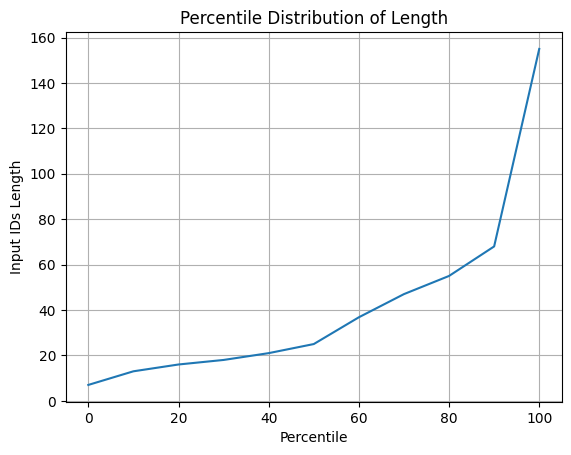

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def preprocess_function(examples):
    return tokenizer(examples['input_text'].split('<|sql|>')[-1])

tokenized_ds = dataset['validation'].map(
    preprocess_function,
    remove_columns=dataset['validation'].column_names,
)

input_ids_lengths = []

for prompt in tokenized_ds:
  input_ids_lengths.append(len(prompt['input_ids']))


percentiles = np.percentile(input_ids_lengths, range(0, 101, 10))

plt.plot(range(0, 101, 10), percentiles)
plt.xlabel("Percentile")
plt.ylabel("Input IDs Length")
plt.title("Percentile Distribution of Length")
plt.grid(True)
plt.show()

In [ ]:
import transformers
from tqdm import tqdm

STOP_WORDS = [';', ');', '\';', '";', '<|endoftext|>']

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords_ids:list):
        self.keywords = keywords_ids

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if input_ids[0][-1] in self.keywords:
            return True
        return False

def get_stopping_criteria(tokenizer, stop_words=STOP_WORDS):
    stop_ids = [tokenizer.encode(w)[0] for w in stop_words]
    keyword_criteria = KeywordsStoppingCriteria(stop_ids)
    stopping_criteria = StoppingCriteriaList([keyword_criteria])
    return stopping_criteria

def get_pipeline(model, tokenizer):
    pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )
    return pipeline

def generate(model, tokenizer, inference_dataloader, max_length=512, max_new_tokens=20, limit_generation=None):
    stopping_criteria = get_stopping_criteria(tokenizer)
    results = []

    generation_config = model.generation_config
    generation_config.max_new_tokens = max_new_tokens
    generation_config.temperature = 0.2
    generation_config.num_return_sequences = 1
    generation_config.pad_token_id = tokenizer.eos_token_id
    generation_config.eos_token_id = tokenizer.eos_token_id
    generation_config.max_length = max_length


    for batch in tqdm(inference_dataloader):
        encoding = tokenizer(batch, return_tensors="pt").to(model.device)
        with torch.inference_mode():
            outputs = model.generate(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"],
                generation_config=generation_config,
                stopping_criteria=stopping_criteria,
                do_sample=False,
                use_cache=True,
            )
        for output in outputs:
            output = tokenizer.decode(output).split('<|sql|>')[-1]
            results.append(output)
        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results

def generate_pipeline(pipeline,
                      inference_dataloader,
                      eos_token_id,
                      pad_token_id,
                      limit_generation=None,
                      max_new_tokens=20,
                      ):
    results = []
    for batch in tqdm(inference_dataloader):
        out = pipeline(batch,
                       do_sample=False,
                       max_new_tokens=max_new_tokens,
                       temperature=0.2,
                       top_k=3,
                       top_p=0.9,
                       repetition_penalty=1.2,
                       num_return_sequences=1,
                       eos_token_id=eos_token_id,
                       pad_token_id=pad_token_id,)
        for res in out:
            prediction = res[0]['generated_text'].split('<|sql|>')[-1]
            print(prediction)
            results.append(prediction)

        if limit_generation is not None and len(results) >= limit_generation:
            break
    return results


In [ ]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
%%time
pipeline = get_pipeline(model, tokenizer)
results = generate_pipeline(pipeline, inference_dataloader, tokenizer.eos_token_id, tokenizer.pad_token_id, max_new_tokens=68) # max new tokens is 160 because the 90th percentile of the input ids length is 160
save_path = './falcon7b6ep.txt'
print('Saving inferences on ', save_path)
with open(save_path, 'w') as f:
    f.write("<separator>".join(results))

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausa

select count(*) from singer;


  0%|          | 2/1034 [00:21<2:50:57,  9.94s/it]

select count(*) from singer;


  0%|          | 3/1034 [00:36<3:27:21, 12.07s/it]

select name,  country,  age from singer order by age desc;


  0%|          | 4/1034 [00:51<3:44:50, 13.10s/it]

select name,  country,  age from singer order by age desc;


  0%|          | 5/1034 [01:18<5:12:08, 18.20s/it]

select avg(age),  min(age),  max(age) from singer where country  =  "france";


  1%|          | 6/1034 [01:46<6:08:08, 21.49s/it]

select avg(age),  min(age),  max(age) from singer where country  =  "france";


  1%|          | 7/1034 [02:46<9:44:13, 34.13s/it]

select t2.song_name,  t2.song_release_year from singer_in_concert as t1 join singer as t2 on t1.singer_id  =  t2.singer_id order by t1.singer_id asc limit 1;


  1%|          | 8/1034 [03:06<8:29:22, 29.79s/it]

select song_name,  song_release_year from singer order by age limit 1;


  1%|          | 9/1034 [03:21<7:10:14, 25.19s/it]

select country from singer where age  >  20 group by country;


  1%|          | 10/1034 [03:34<6:01:25, 21.18s/it]

select country from singer where age  >  20;


/home/CIN/gme/TCC/base/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  1%|          | 11/1034 [03:47<5:19:47, 18.76s/it]

select country,  count(*) from singer group by country;


  1%|          | 12/1034 [04:00<4:51:03, 17.09s/it]

select country,  count(*) from singer group by country;


  1%|          | 12/1034 [04:01<5:42:09, 20.09s/it]


KeyboardInterrupt: 

: 

In [ ]:
# save_path = './falcon7binstruct.txt'

In [ ]:
# print('Saving inferences on ', save_path)
# with open(save_path, 'w') as f:
#     f.write("<separator>".join(results))